# Example 2: Recording iterations during a solve with an intermediate callback

Optimization solvers are notorious black boxes. To understand or visualize what they are doing, or to debug failures, it is often useful to inspect the trajectory a solver takes from the initial point to (hopefully) a
solution. This tutorial shows how to do this with Ipopt's intermediate callback, CyIpopt, and PyNumero.

This tutorial will use an example from power systems: The optimal power flow problem. We use [Egret](https://github.com/grid-parity-exchange/Egret) (`pip install gridx-egret` should work) and [PGLib-OPF](https://github.com/power-grid-lib/pglib-opf) to construct the Pyomo model. We assume a `pglib-opf` directory exists in our current working directory, which contains the contents of the linked repository.

Some imports and path bookkeeping.

In [24]:
import os
import pyomo.environ as pyo
from pyomo.common.collections import ComponentMap
from pyomo.contrib.pynumero.interfaces.pyomo_nlp import PyomoNLP
from egret.parsers.matpower_parser import create_ModelData
from egret.models.acopf import create_psv_acopf_model
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
import matplotlib

fname = "pglib_opf_case118_ieee.m"
fpath = os.path.join("pglib-opf", fname)

Now we'll parse the input data file (known as a Matpower file) into Egret's `ModelData` data structure
and construct some additional data structures that will be useful later.

In [4]:
data = create_ModelData(fpath)

generator_lookup = dict(data.elements("generator"))
bus_lookup = dict(data.elements("bus"))
online_generators = [i for i, g in data.elements("generator") if g["in_service"]]
sorted_generators = sorted(online_generators, key=lambda i: generator_lookup[i]["p_max"], reverse=True)
nonreference_generators = [
    i for i in sorted_generators
    if bus_lookup[generator_lookup[i]["bus"]]["matpower_bustype"] != "ref"
]

We are ready to create the Pyomo model. Let's see if it solves.

In [5]:
# This constructs an optimal power flow problem, using the "rectangular power-polar voltage" coordinate
# system. Don't worry about it if you don't know what that is.
# The second output here is the ModelData object, which we already have.
m, _ = create_psv_acopf_model(data)
solver = pyo.SolverFactory("cyipopt")
res = solver.solve(m, tee=True)
pyo.assert_optimal_termination(res)

WARNING (W1002): Setting Var 'vm['4']' to a numeric value `1.0600000048974205`
outside the bounds (0.94, 1.06).
    See also https://pyomo.readthedocs.io/en/stable/errors.html#w1002
WARNING (W1002): Setting Var 'vm['9']' to a numeric value `1.0600000051741287`
outside the bounds (0.94, 1.06).
    See also https://pyomo.readthedocs.io/en/stable/errors.html#w1002
WARNING (W1002): Setting Var 'vm['17']' to a numeric value
`1.0600000045856877` outside the bounds (0.94, 1.06).
    See also https://pyomo.readthedocs.io/en/stable/errors.html#w1002
WARNING (W1002): Setting Var 'vm['25']' to a numeric value
`1.0600000052139866` outside the bounds (0.94, 1.06).
    See also https://pyomo.readthedocs.io/en/stable/errors.html#w1002
WARNING (W1002): Setting Var 'vm['37']' to a numeric value `1.060000004966313`
outside the bounds (0.94, 1.06).
    See also https://pyomo.readthedocs.io/en/stable/errors.html#w1002
WARNING (W1002): Setting Var 'vm['59']' to a numeric value
`1.0600000045409927` outside 

WARNING (W1002): Setting Var 'qg['35']' to a numeric value
`0.23000000744487295` outside the bounds (-0.08, 0.23).
    See also https://pyomo.readthedocs.io/en/stable/errors.html#w1002
WARNING (W1002): Setting Var 'qg['38']' to a numeric value
`0.23000000197224058` outside the bounds (-0.08, 0.23).
    See also https://pyomo.readthedocs.io/en/stable/errors.html#w1002
WARNING (W1002): Setting Var 'qg['47']' to a numeric value
`0.23000000039388002` outside the bounds (-0.08, 0.23).
    See also https://pyomo.readthedocs.io/en/stable/errors.html#w1002


Looks good. Now we want to track the state during the solve. Let's create a fresh model.

In [6]:
m, _ = create_psv_acopf_model(data)
m.ipopt_zL_out = pyo.Suffix(direction=pyo.Suffix.IMPORT)
m.ipopt_zU_out = pyo.Suffix(direction=pyo.Suffix.IMPORT)
m.dual = pyo.Suffix(direction=pyo.Suffix.IMPORT_EXPORT)

We'll track the state with a callback object that we'll send to CyIpopt.
The "intermediate callback" that our CyIpopt interface accepts is a 13-argument function. We'll create
a callable class so we can easily store the iterations somewhere.

In [7]:
class Callback:
    
    def __init__(self):
        self.iterate_data = []

    def __call__(
        self,
        nlp,
        ipopt_problem,
        alg_mod,
        iter_count,
        obj_value,
        inf_pr,
        inf_du,
        mu,
        d_norm,
        regularization_size,
        alpha_du,
        alpha_pr,
        ls_trials,
    ):
        """Intermediate callback in the Pyomo CyIpopt interface is a 13-argument
        function
        """
        # The best way to get the current iterate is with the CyIpopt get_current_iterate method.
        # This only works with Ipopt 3.14. For earlier Ipopt, you can use nlp.get_primals and
        # nlp.get_duals, but this has two problems: 1. You don't have bound multipliers
        # and 2. primals and duals are not necessarily from the same iteration.
        iterate = ipopt_problem.get_current_iterate(scaled=False)
        # See here: https://cyipopt.readthedocs.io/en/stable/reference.html
        # for the keys of the dict that this function returns.
        primals = iterate["x"]
        duals = iterate["mult_g"]
        lbmult = iterate["mult_x_L"]
        ubmult = iterate["mult_x_U"]
        data = dict(primals=primals, duals=duals, lbmult=lbmult, ubmult=ubmult)
        self.iterate_data.append(data)
        
callback = Callback()

We have created a callback object. Did that work? Can we track the primal and dual variable values during
a solve?

In [9]:
solver.config.intermediate_callback = callback
# Can also set `options=dict(intermediate_callback=callback)` when constructing cyipopt.
res = solver.solve(m, tee=True)
pyo.assert_optimal_termination(res)
# Do we have about the right number of iterations?
print(f"N. iter: {len(callback.iterate_data)}")

WARNING (W1002): Setting Var 'vm['4']' to a numeric value `1.0600000048974185`
outside the bounds (0.94, 1.06).
    See also https://pyomo.readthedocs.io/en/stable/errors.html#w1002
WARNING (W1002): Setting Var 'vm['9']' to a numeric value `1.0600000051741287`
outside the bounds (0.94, 1.06).
    See also https://pyomo.readthedocs.io/en/stable/errors.html#w1002
WARNING (W1002): Setting Var 'vm['17']' to a numeric value
`1.0600000045856877` outside the bounds (0.94, 1.06).
    See also https://pyomo.readthedocs.io/en/stable/errors.html#w1002
WARNING (W1002): Setting Var 'vm['25']' to a numeric value
`1.0600000052139866` outside the bounds (0.94, 1.06).
    See also https://pyomo.readthedocs.io/en/stable/errors.html#w1002
WARNING (W1002): Setting Var 'vm['37']' to a numeric value
`1.0600000049663045` outside the bounds (0.94, 1.06).
    See also https://pyomo.readthedocs.io/en/stable/errors.html#w1002
WARNING (W1002): Setting Var 'vm['59']' to a numeric value `1.060000004540994`
outside 

WARNING (W1002): Setting Var 'qg['35']' to a numeric value
`0.23000000744487295` outside the bounds (-0.08, 0.23).
    See also https://pyomo.readthedocs.io/en/stable/errors.html#w1002
WARNING (W1002): Setting Var 'qg['38']' to a numeric value
`0.23000000197224058` outside the bounds (-0.08, 0.23).
    See also https://pyomo.readthedocs.io/en/stable/errors.html#w1002
WARNING (W1002): Setting Var 'qg['47']' to a numeric value
`0.23000000039388002` outside the bounds (-0.08, 0.23).
    See also https://pyomo.readthedocs.io/en/stable/errors.html#w1002
N. iter: 52


We have recorded primal and dual values in the order defined by `get_current_iterate`.
Let's make sure this is the same order as stored in a `PyomoNLP`.

In [10]:
nlp = PyomoNLP(m)
assert all(nlp.get_primals() == callback.iterate_data[-1]["primals"])
assert all(nlp.get_duals() == callback.iterate_data[-1]["duals"])

Now we can plot the state trajectory for variables we're interested in. We'll plot two variables,
each with its own axis.

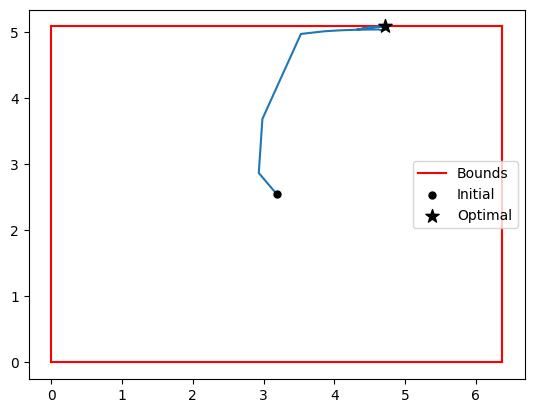

In [36]:
# These are the data structures we created above.
g1 = nonreference_generators[2]
g2 = nonreference_generators[3]
plotvars = [m.pg[g1], m.pg[g2]]
indices = nlp.get_primal_indices(plotvars)

plotdata = [
    [data["primals"][i] for data in callback.iterate_data]
    for i in indices
]
x, y = plotvars
xdata, ydata = plotdata

# Plot state trajectories
def plot_state_trajectories():
    """Note that this function relies on global variables"""
    fig, ax = plt.subplots()
    ax.plot([x.lb, x.ub], [y.lb, y.lb], color="red", label="Bounds")
    ax.plot([x.lb, x.ub], [y.ub, y.ub], color="red")
    ax.plot([x.lb, x.lb], [y.lb, y.ub], color="red")
    ax.plot([x.ub, x.ub], [y.lb, y.ub], color="red")
    ax.plot(xdata, ydata)
    ax.scatter([xdata[0]], [ydata[0]], marker=".", s=100, label="Initial", color="black", zorder=10)
    ax.scatter([xdata[-1]], [ydata[-1]], marker="*", s=100, label="Optimal", color="black", zorder=10)
    ax.legend()
    return fig, ax

fig, ax = plot_state_trajectories()

We have the plot that we want. This is a very simple example of what we can do with the iterate data. We could imagine computing much more complicated values, like condition numbers or inertia.

For now, let's make this plot a little bit more interesting by adding contours of the objective. Contours are
level sets of our objective, projected onto the feasible space of our problem (projected again onto the
two variables we're plotting). To a second-order approximation, we just want the ellipsoid defined by the reduced
Hessian (viewed as a quadratic function) projected onto these two variables.

I've included the functionality for constructing the reduced Hessian, from the previous example, in a file
called `reduced_hessian.py`. Let's use it to add some contours to this plot.

In [23]:
from reduced_hessian import (
    get_reduced_hessian,
    get_gradient_of_lagrangian,
    project_onto, # This is for projecting the RH onto the two coordinates we care about
)
lbmult = [m.ipopt_zL_out[x] for x in nlp.get_pyomo_variables()]
ubmult = [m.ipopt_zU_out[x] for x in nlp.get_pyomo_variables()]
# Sanity check
gradlag = get_gradient_of_lagrangian(nlp, lbmult, ubmult)
assert all(abs(gradlag) <= 1e-7)

To construct the reduced Hessian, we need to know (a valid set of) degrees of freedom. Let's construct these
and test that the resulting the Jacobian with respect to basic variables is nonsingular.

In [26]:
# In ACOPF, degrees of freedom are typically real and reactive power at generator buses
# (except at the reference bus, which has one fewer degree of freedom)
dofvars = [m.pg[i] for i in nonreference_generators] + list(m.qg.values())
dofvar_map = ComponentMap((v, i) for i, v in enumerate(dofvars))
basicvars = [v for v in nlp.get_pyomo_variables() if v not in dofvar_map]
eqcons = nlp.get_pyomo_equality_constraints()
basic_submatrix = nlp.extract_submatrix_jacobian(basicvars, eqcons)
print(basic_submatrix.shape)
lu = sp.sparse.linalg.splu(basic_submatrix.tocsc())
cond = np.linalg.cond(basic_submatrix.toarray())
print(f"Condition number of basic submatrix: {cond:1.2E}")

(1635, 1635)
Condition number of basic submatrix: 2.76E+06


We have valid degrees of freedom. Now we can construct the reduced Hessian.

In [28]:
rh = get_reduced_hessian(nlp, dofvars, lbmult, ubmult)
# `x` and `y` are the variables we're plotting.
plot_indices = [dofvar_map[x], dofvar_map[y]]
# This just gets the symmetric matrix descriping the ellipse in the two coordinates
# we care about. It does this with a Schur complement.
projected_rh = project_onto(rh, plot_indices)
evals, evecs = np.linalg.eig(projected_rh)
assert all(evals > 0)

The function $(x - x^*)^T \mathcal{H}_r (x - x^*)$ is a second-order approximation of our objective function,
projected onto the feasible space.
The contours we want to plot are level sets of this function (projected onto our two variables).
The level sets are ellipsoids with axes in the direction of the (orthogonal) eigenvectors
and lengths proportional to the (real) eigenvalues.

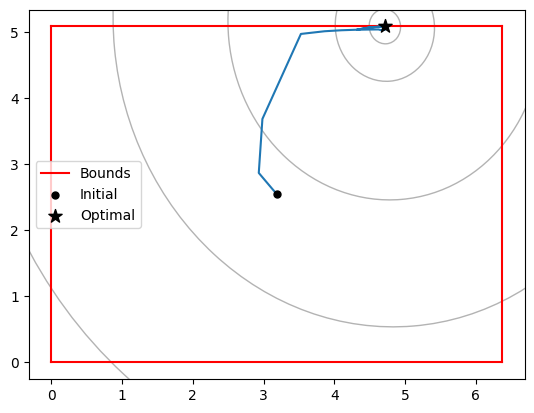

In [55]:
def plot_trajectories_with_contours():
    fig, ax = plot_state_trajectories()
    # Center our contours on the optimal termination point
    center = (xdata[-1], ydata[-1])
    # The angle that Ellipse expects is defined by the second eigenvector, for some reason.
    angle = np.rad2deg(np.arctan2(evecs[1,0], evecs[1,1]))
    levels = [1e0, 1e1, 1e2, 3e2, 7e2]
    xlim = ax.get_xlim()
    ylim = ax.get_ylim()
    for l in levels:
        # Here we're taking level sets of the function:
        # (1/2) x^T A x, for some reason.
        width = 2 * (l / evals[0])**0.5
        height = 2 * (l / evals[1])**0.5
        ellipse = matplotlib.patches.Ellipse(
            center,
            width=width,
            height=height,
            angle=angle,
            edgecolor=tuple([0.7]*3),
            facecolor="none",
        )
        ax.add_patch(ellipse)
    # Reset plot limits so these aren't influenced by ellipses
    ax.set_xlim(xlim)
    ax.set_ylim(ylim)
    return fig, ax

fig, ax = plot_trajectories_with_contours()
plt.show()

That's it! We've recorded the state trajectory, plotted it in two dimensions, and used the reduced Hessian to
plot (approximate) contours of the objective function.

Again, go try this out on your models! Will looking at state trajectories in two dimensions give you some
fundamental yet practical insight into your model or the Ipopt algorithm? Maybe not, but it might!
If the trajectory of some variable is jumping around to a weird region, maybe you need to add a bound.
If the eigenvalues of the reduced Hessian are wildly different, maybe you need to reconsider your
problem's scaling.